In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random
import psutil
import gc

In [2]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

DateString = 'Good'
LastGoodModel = 40

TIME_STEPS = 1200
Skips = 600
RollSize = 50

LastSuccesfull = 40

tic = ti()
start = tic

MemoryProtection = True


In [3]:
%matplotlib inline

In [4]:
FilesPerRun = 5
ConcurrentFiles = 5

In [5]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

def split_list_by_ones(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    for i in range(int((len(values) - time_steps + skips)/skips)):
        output.append(values[i*skips : (i*skips + time_steps)])
    return np.stack(output)

In [6]:
def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

In [7]:
def runFile(file, verbose = False, small = False, index=0, start=ti()):
    noise = verbose
    dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')
    
    
    dataset = dataset.rename(columns={0:"Day"})
    dataset = dataset.rename(columns={1:"Second"})
    dataset = dataset.rename(columns={2:"FracSec"})
    dataset = dataset.rename(columns={3:"p"})
    dataset = dataset.rename(columns={4:"h"})
    dataset = dataset.rename(columns={5:"v"})
    dataset = dataset.rename(columns={6:"Sensor"})
    
    #dataset['Second'].replace('',0)
    #dataset['FracSec'].replace('',0)
    #dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)
    
    #dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
    #dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))
    
    #dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
    #dataset["timestamps"] = dataset["timestamp"]
    
    dataset["p"] = dataset.p - np.average(dataset.p)
    dataset["h"] = dataset.h - np.average(dataset.h)
    dataset["v"] = dataset.v - np.average(dataset.v)
    #dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)
    
    #dataset.index = dataset.timestamp
    
    dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    #dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    
    
    RawData = dataset.v
    SmoothData = dataset.SmoothV
    RollSize = 25
    
    Diffs = RawData - SmoothData
    
    Sqs = Diffs * Diffs
    
    Sqs = Sqs.tolist() 
    
    Sqs.extend(np.zeros(RollSize))
    
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    
    VarVect = sVect / eVect
    
    StdDevs = np.sqrt(VarVect)
    
    StdDevsZ = np.asarray(StdDevs)
    
    StdDevsZ=np.append(StdDevsZ,[0])
    
    StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])
    
    print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))
    
    StdDevsZ = np.nan_to_num(StdDevsZ)
    
    StdDevsZ[StdDevsZ == np.inf] = 0
    StdDevsZ[StdDevsZ == -np.inf] = 0
    
    SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')
    
    print("denoise 1", ti()-start, np.shape(StdDevsZ))
    
    fig=plt.figure()
    plt.plot(SmoothDevZ)
    plt.show()
    
    SmoothDevZ[np.isnan(SmoothDevZ)]=0
    
    Max = np.max(SmoothDevZ)
    
    buckets = int(Max / 0.005) + 1
    bins = np.linspace(0,buckets*0.005,buckets+1)
    counts, bins = np.histogram(SmoothDevZ,bins=bins)
    
    CummCount = 0
    HalfWay = 0
    for i in range(len(counts)):
        CummCount += counts[i]
        if CummCount / len(SmoothDevZ) >= 0.5:
            if HalfWay == 0:
                HalfWay = i
    
    SquelchLevel = bins[HalfWay] 
    
    
    dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 2000, 0.02, False)
    
    
    velocity = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)
    
    df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
    df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
    df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)
    
    df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
    df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
    df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)
    
    SmoothMove = []
    for i in range(len(df_pr)):
        if len(df_pr[i])>TIME_STEPS:
            tempP=create_sequences(df_pr[i])
            tempH=create_sequences(df_hr[i])
            tempV=create_sequences(df_vr[i])
            for j in range(len(tempP)):
                SmoothMove.append(np.vstack((tempP[j],tempH[j],tempV[j]))) #,df_rs[i])))
    
    SmoothStop = []
    for i in range(len(df_ps)):
        if len(df_ps[i])>TIME_STEPS:
            tempP=create_sequences(df_ps[i])
            tempH=create_sequences(df_hs[i])
            tempV=create_sequences(df_vs[i])
            for j in range(len(tempP)):
                SmoothStop.append(np.vstack((tempP[j],tempH[j],tempV[j]))) #,df_rs[i])))
    return SmoothMove,SmoothStop, velocity
    #else:
    #    return ['fail','fail']
        
        #if verbose:
        #    print('Data normalized', ti()-start)

        #return df_p, df_h, df_v, df_r, df_rp, df_rh, df_rv, df_rr


In [8]:
import CoreFunctions as cf

In [9]:
def runWrapper(file_path, verbose=True, small=False, index=0, start=ti()):
    #try:
    rtrn = runFile(file_path, verbose, small, index, start)
    return rtrn
    #except Exception as e:
    #    with open('BadInputs.text', 'a') as bad_file:
    #        bad_file.write(file_path + '\n')
    #    return np.zeros((10, 10, 3))

In [10]:
def PrintWrap(Mat):
    localPrints = []
    lenm = np.shape(Mat)[1]
    slices = int(lenm/TIME_STEPS)
    for i in range(slices):
        temp = (cf.makeMPFast(Mat[:3,i*TIME_STEPS:(i+1)*TIME_STEPS], wvt = 'sym4', scales = 32, spacer = 2, title = ''))
        localPrints.append(temp.astype(np.float32)/255.0)
    return localPrints

# Start Machine Learning
## Using Autoencoder with Kears and Tensorflow
cite: https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

In [11]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

2024-12-08 11:25:18.905460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 11:25:18.926954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 11:25:18.933531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 11:25:18.949304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=24):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [13]:
# set the matplotlib backend so figures can be saved in the background
#import matplotlib
#matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments

In [14]:
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

In [15]:
from tensorflow.keras.callbacks import Callback

In [16]:
import keras
import re

In [17]:
directory = '/scratch/models/'
target_file = f'3DFP_{DateString}_{str(LastGoodModel).zfill(3)}_good2_ae.keras'

ImageShape=[5,32,600,3]

encoder = load_model(directory+target_file[:-8]+'en.keras')
decoder = load_model(directory+target_file[:-8]+'de.keras')

autoencoder_input = Input(shape=(ImageShape[1], ImageShape[2], ImageShape[3]))

# Pass the input through the encoder and decoder
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

# Create the reassembled autoencoder model
autoencoder = Model(autoencoder_input, reconstructed)

2024-12-08 11:25:22.592153: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (34)


In [18]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())
#if LastSuccesfull != 0:
#    print(reautoencoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 300, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 300, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 300, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 150, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 150, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 150, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,228,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249,472 (4.77 MB)

 Trainable params: 1,249,280 (4.77 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38400)          │     1,267,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 150, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 300, 32)    │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 300, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 300, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 600, 64)    │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 600, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 600, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 600, 3)     │         1,731 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 600, 3)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,059 (4.95 MB)

 Trainable params: 1,296,867 (4.95 MB)

 Non-trainable params: 192 (768.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │     1,249,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 600, 3)     │     1,297,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,531 (9.71 MB)

 Trainable params: 2,546,147 (9.71 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [19]:
def getTensors(file_list):

    AllDatas = Parallel(n_jobs=ConcurrentFiles)(delayed(runWrapper)(file_list[i], False, False, 0, ti()) for i in range(min(len(file_list),FilesPerRun)))

    Mats=[]
    Runs=[]

    for fileResponse in AllDatas:
        for Mat in fileResponse[0]:
            Mats.append(Mat)
        for Mat in fileResponse[1]:
            Runs.append(Mat)
        fig = plt.figure()
        plt.plot(fileResponse[2])
        plt.show()
        
            
    if MemoryProtection:
        del AllDatas
        print('RAM after AllData:', psutil.virtual_memory()[2], len(Mats))        

    AllPrints = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Mats)
    AllRuns = Parallel(n_jobs=8)(delayed(PrintWrap)(Mat) for Mat in Runs)
    
    if MemoryProtection:
        del Mats, Runs
        print('RAM after Keeps:', psutil.virtual_memory()[2])
    
    Prints = []
    Rprint = []    
    for group in AllPrints:
        for fprint in group:
            Prints.append(fprint[:, ::2, :])
    for group in AllRuns:
        for fprint in group:
            Rprint.append(fprint[:, ::2, :])
    
    if MemoryProtection:
        del AllPrints, AllRuns
    random.shuffle(Prints)
    random.shuffle(Rprint)
    
    for i, image in enumerate(Prints):
        if not isinstance(image, np.ndarray):
            Prints[i] = np.array(image, dtype=np.float32)
        elif image.dtype != np.float32:
            Prints[i] = image.astype(np.float32)
    for i, image in enumerate(Rprint):
        if not isinstance(image, np.ndarray):
            Rprint[i] = np.array(image, dtype=np.float32)
        elif image.dtype != np.float32:
            Rprint[i] = image.astype(np.float32)
    
    # Stack the images into a single NumPy array
    prints_array = np.stack(Prints, axis=0)
    rprint_array = np.stack(Rprint, axis=0)
    
    if MemoryProtection:
        del Prints, Rprint
        print('RAM after Prints:', psutil.virtual_memory()[2])
    # Convert the NumPy array to a TensorFlow tensor
    trX = tf.convert_to_tensor(prints_array)
    trR = tf.convert_to_tensor(rprint_array)
    
    if MemoryProtection:
        del prints_array, rprint_array
    return trX, trR

In [20]:
files=['230704 recording4.csv',
       '230421 recording1.csv',
       '230420 recording2.csv',
       ]

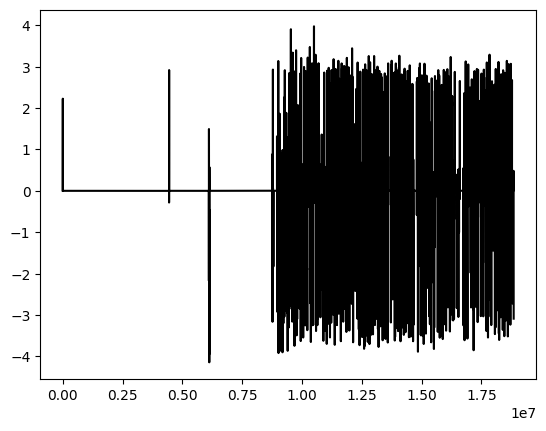

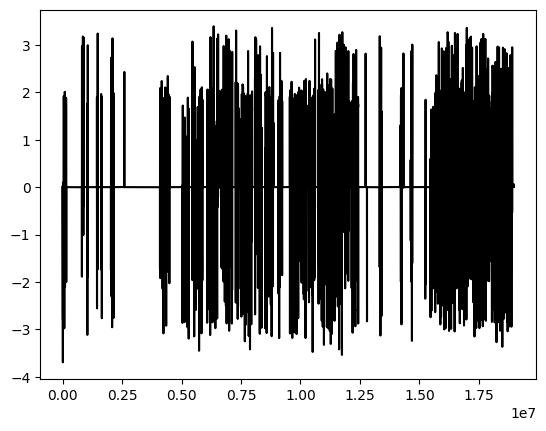

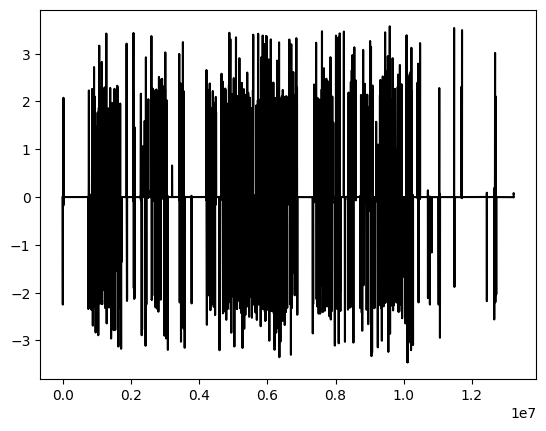

RAM after AllData: 5.0 7316
Size StdDevsZ 138.20277380943298 (13226070,)
denoise 1 139.05150985717773 (13226070,)
Figure(640x480)
Size StdDevsZ 203.32395911216736 (18968160,)
denoise 1 204.54517722129822 (18968160,)
Figure(640x480)
Size StdDevsZ 203.4254596233368 (18850628,)
denoise 1 204.63294219970703 (18850628,)
Figure(640x480)
RAM after Keeps: 17.7
RAM after Prints: 24.6


In [21]:
Moves, Stops = getTensors(files)

In [22]:
len(Moves)

7316

In [23]:
len(Stops)

74122

In [24]:
MovePred = autoencoder.predict(Moves)
StopPred = autoencoder.predict(Stops)

229/229 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step
2317/2317 ━━━━━━━━━━━━━━━━━━━━ 297s 128ms/step


In [25]:
Diff_Move = Moves-MovePred
Diff_Stop = Stops-StopPred

In [26]:
MSE_Move_Pixel = np.mean(Diff_Move**2,axis=3)
MSE_Stop_Pixel = np.mean(Diff_Stop**2,axis=3)

In [27]:
MSE_Move_Time = np.mean(MSE_Move_Pixel,axis=1)
MSE_Stop_Time = np.mean(MSE_Stop_Pixel,axis=1)

In [28]:
MSE_Move_Frame = np.mean(MSE_Move_Time,axis=1)
MSE_Stop_Frame = np.mean(MSE_Stop_Time,axis=1)
print('RAM after Predictions and Deltas:', psutil.virtual_memory()[2])

RAM after Predictions and Deltas: 33.9


In [29]:
np.shape(Diff_Move)

TensorShape([7316, 32, 600, 3])

In [30]:
np.shape(MSE_Move_Pixel)

(7316, 32, 600)

In [31]:
np.shape(MSE_Move_Time)

(7316, 600)

In [32]:
np.shape(MSE_Move_Frame)

(7316,)

In [33]:
MoveResult = np.mean(MSE_Move_Frame)
StopResult = np.mean(MSE_Stop_Frame)

In [34]:
MoveResult

0.23254168

In [35]:
StopResult

0.20380041

In [36]:
RResultsS = []
RResultsA = []
RResultsM = []
RResultsAM = []
RResultsMS = []
for result in Diff_Move:
    RResultsS.append(np.sum(result))
    RResultsA.append(np.sum(np.abs(result)))
    RResultsM.append(np.mean(result))
    RResultsAM.append(np.mean(np.abs(result)))
    RResultsMS.append(np.mean(result**2))

In [37]:
SResultsS = []
SResultsA = []
SResultsM = []
SResultsAM = []
SResultsMS = []
for result in Diff_Stop:
    SResultsS.append(np.sum(result))
    SResultsA.append(np.sum(np.abs(result)))
    SResultsM.append(np.mean(result))
    SResultsAM.append(np.mean(np.abs(result)))
    SResultsMS.append(np.mean(result**2))

In [38]:
def filter_data(data, min = -np.inf, max = np.inf):
    data = np.array(data)
    data[np.isnan(data)] = 0
    data[np.isinf(data)] = 0
    mean = np.mean(data) 
    std_dev = np.std(data) 
    filtered_data = data[np.abs(data - mean) / std_dev < 2]
    filtered_data = filtered_data[filtered_data > min]
    filtered_data = filtered_data[filtered_data < max]

    return filtered_data

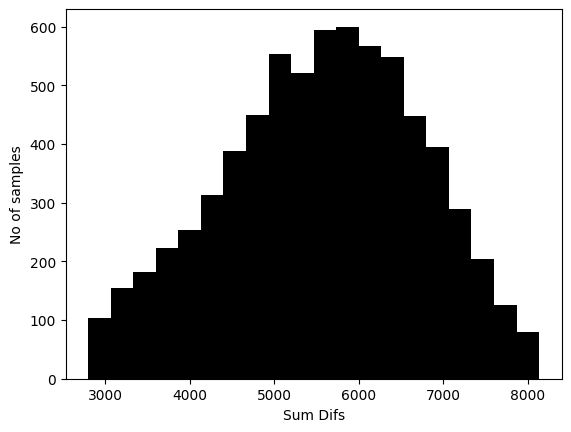

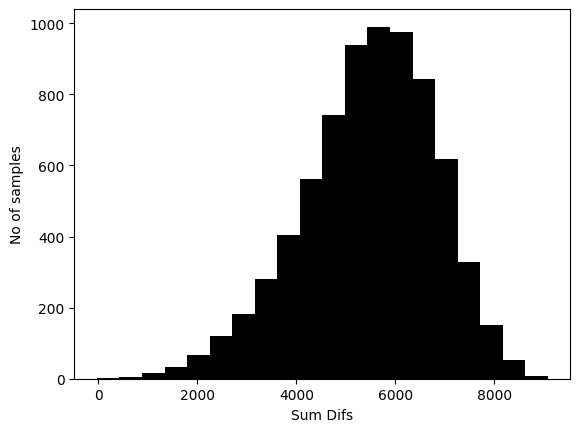

In [39]:
plt.hist(filter_data(RResultsS), bins=20)
plt.xlabel("Sum Difs")
plt.ylabel("No of samples")
plt.show()
plt.hist((RResultsS), bins=20)
plt.xlabel("Sum Difs")
plt.ylabel("No of samples")
plt.show()

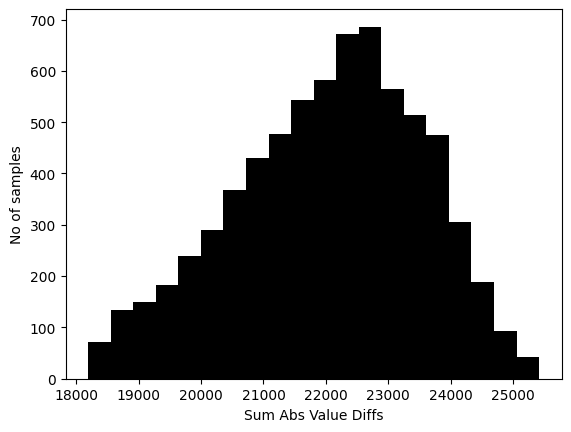

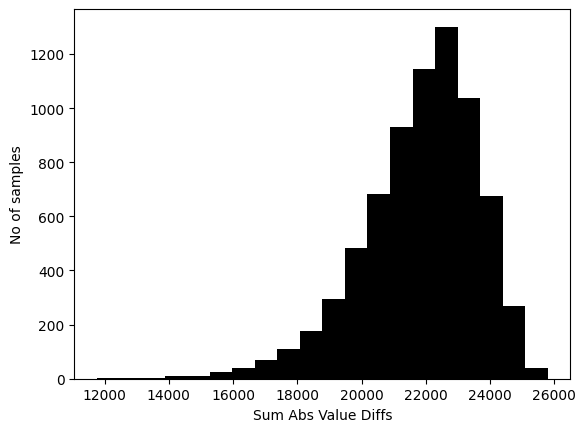

In [40]:
plt.hist(filter_data(RResultsA,0,50000), bins=20)
plt.xlabel("Sum Abs Value Diffs")
plt.ylabel("No of samples")
plt.show()
plt.hist(RResultsA, bins=20)
plt.xlabel("Sum Abs Value Diffs")
plt.ylabel("No of samples")
plt.show()

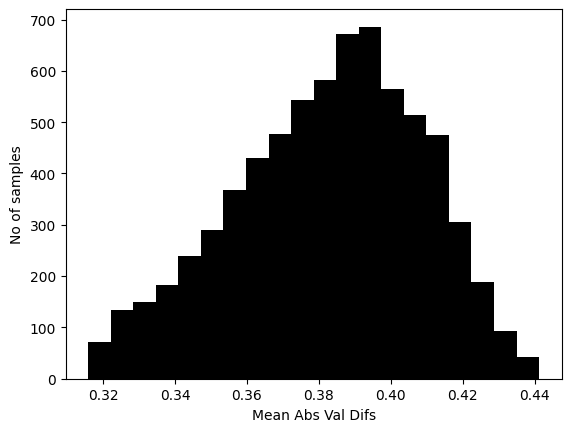

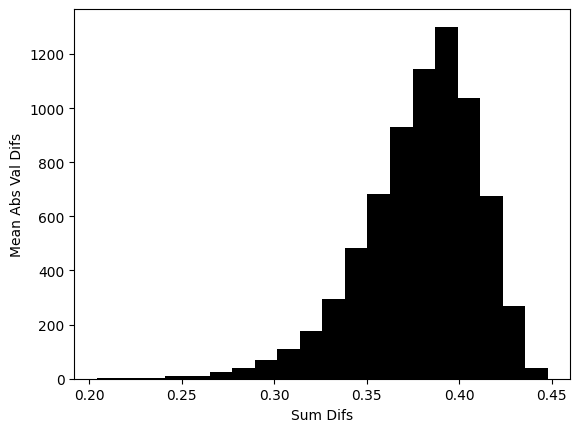

In [41]:
plt.hist(filter_data(RResultsAM,0,2), bins=20)
plt.xlabel("Mean Abs Val Difs")
plt.ylabel("No of samples")
plt.show()
plt.hist(RResultsAM, bins=20)
plt.xlabel("Sum Difs")
plt.ylabel("Mean Abs Val Difs")
plt.show()


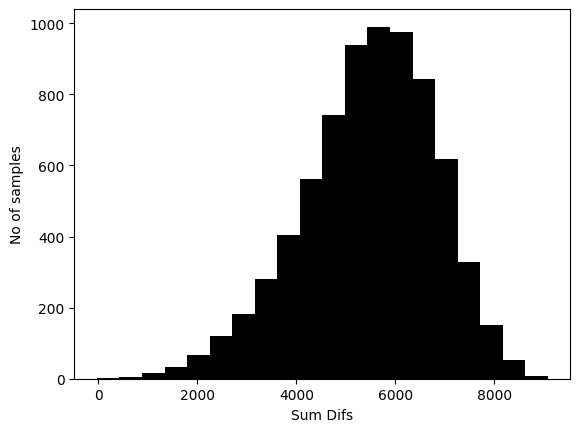

In [42]:
plt.hist((RResultsS), bins=20)
plt.xlabel("Sum Difs")
plt.ylabel("No of samples")
plt.show()

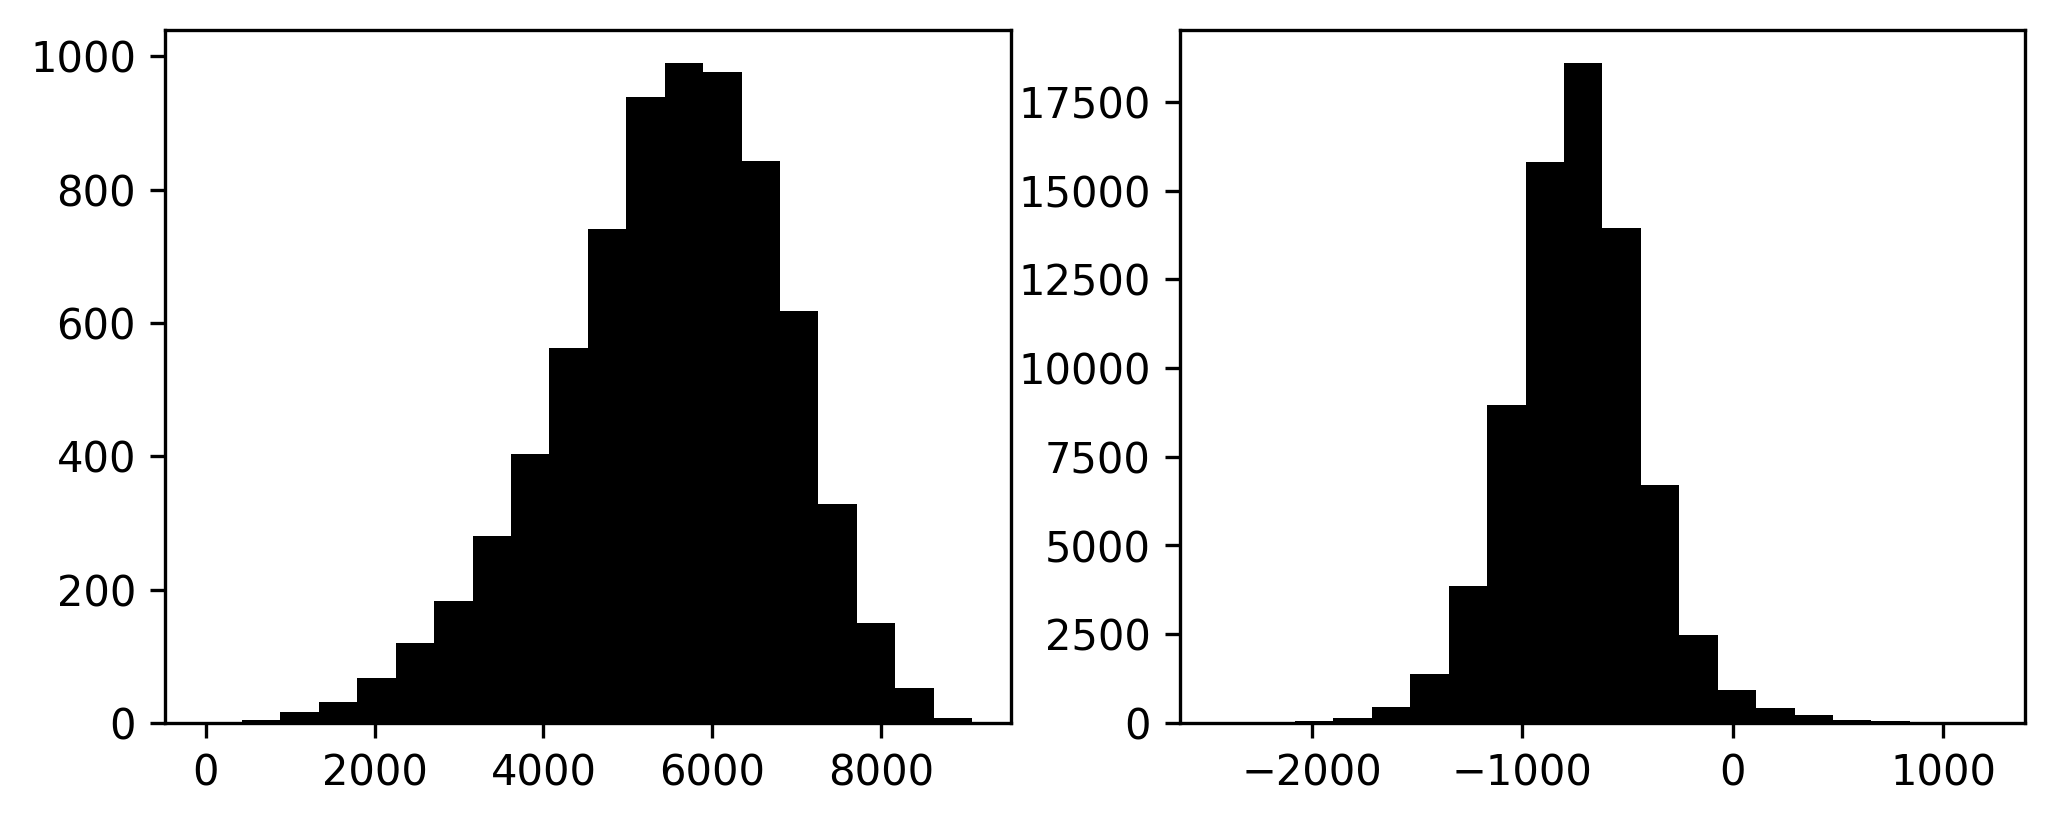

In [43]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(8,3), dpi=300 )
ax0.hist((RResultsS), bins=20)
ax1.hist((SResultsS), bins=20)
plt.show()

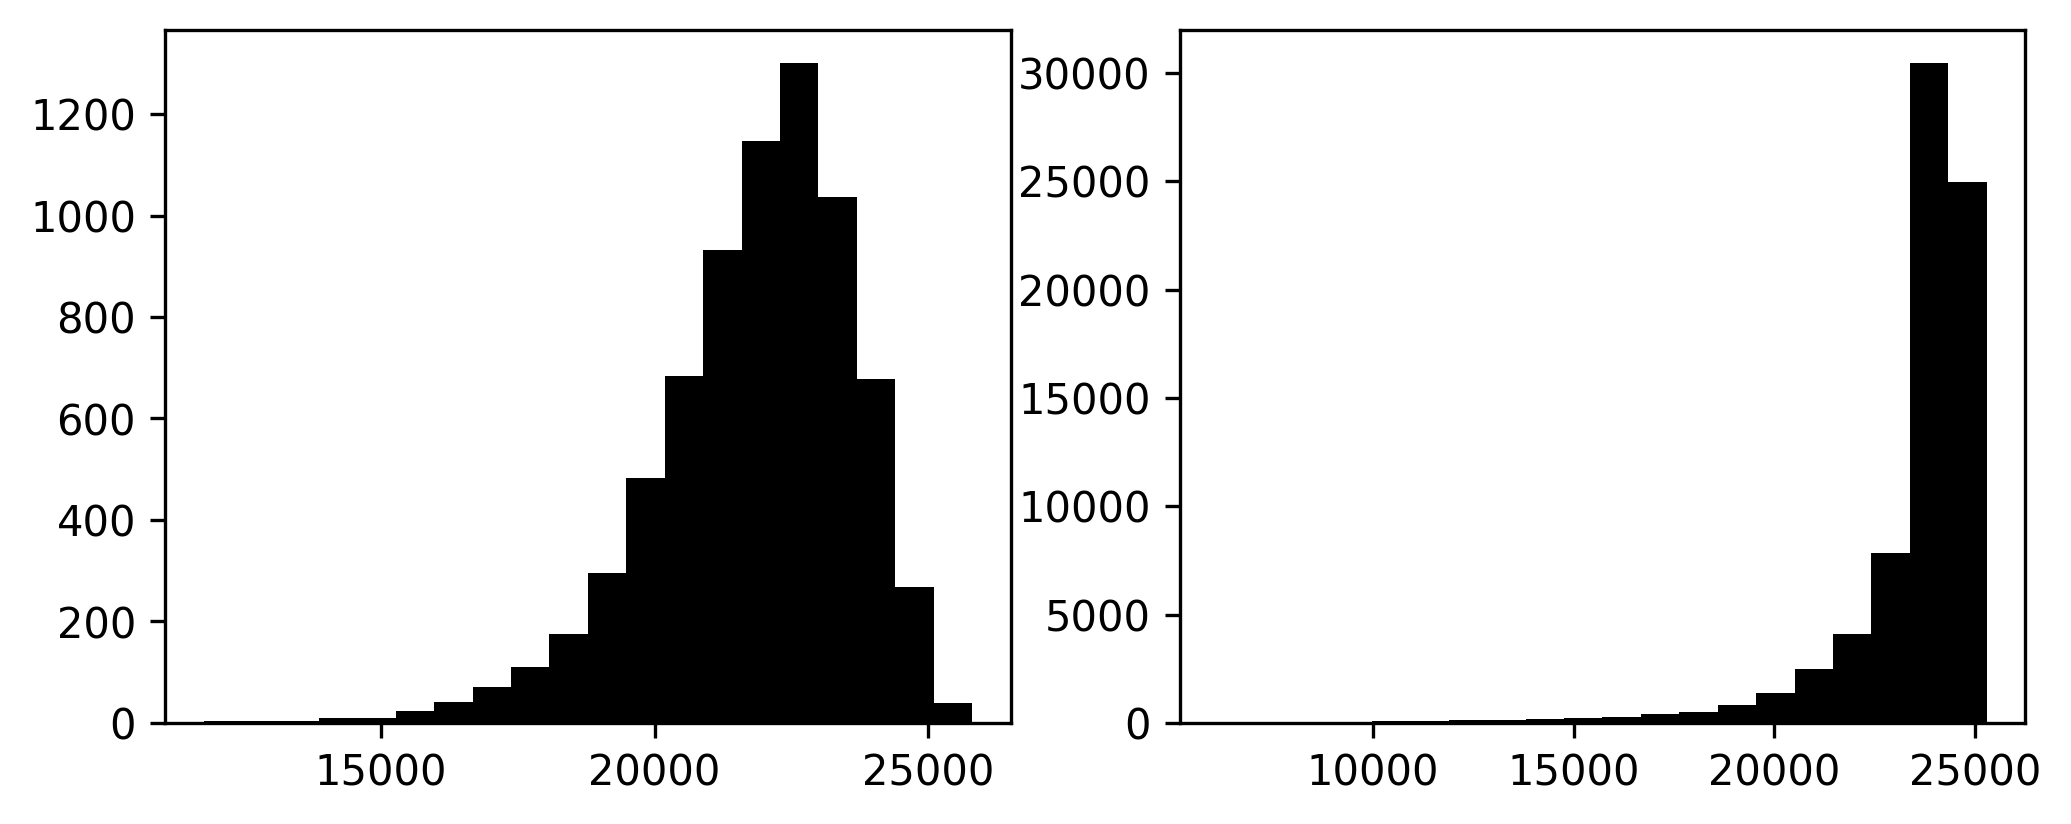

In [44]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(8,3), dpi=300 )
ax0.hist((RResultsA), bins=20)
ax1.hist((SResultsA), bins=20)
plt.show()

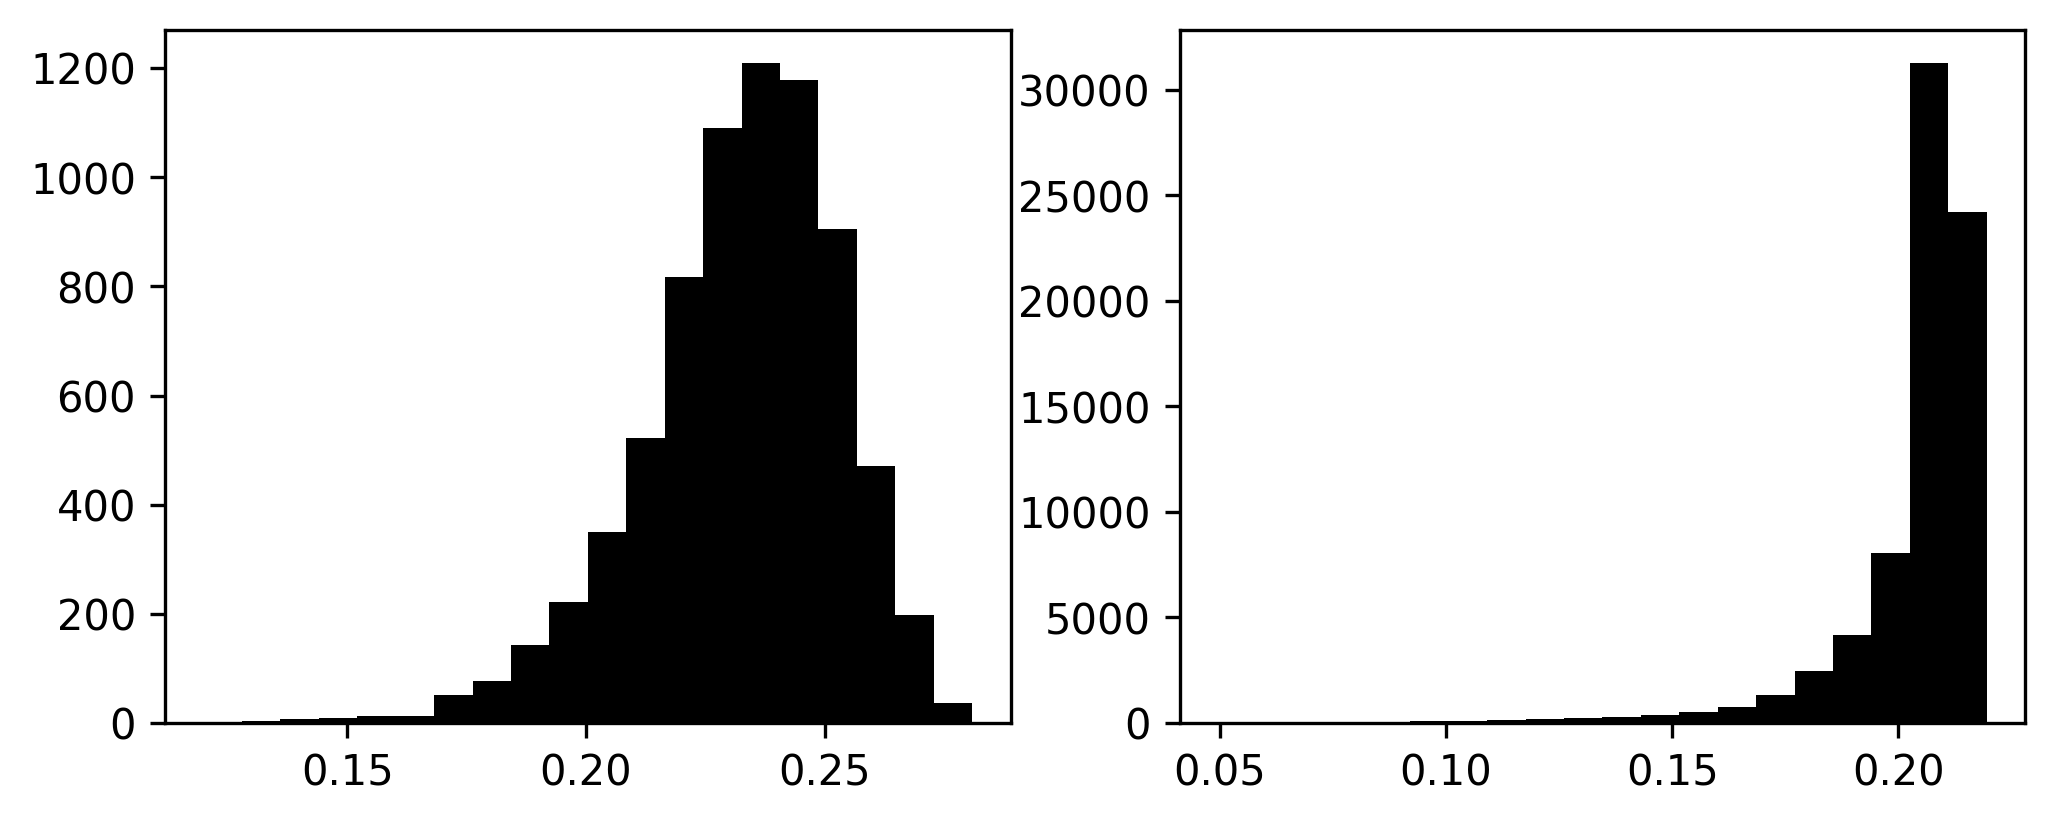

In [45]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(8,3), dpi=300 )
ax0.hist((RResultsMS), bins=20)
ax1.hist((SResultsMS), bins=20)
plt.show()

 - sum difference by color by pixel by time step
 - sum difference by pixel by time step
 - averages diffferences by both
 - graphs of differences over time for a sample

In [46]:
TimeDiffs = np.sum(Deltas, axis=1)
np.shape(TimeDiffs)

NameError: name 'Deltas' is not defined

In [ ]:
TimeDiffsPixel = np.sum(TimeDiffs,axis=2)
np.shape(TimeDiffsPixel)

In [ ]:
fig = plt.figure()
plt.plot(TimeDiffs[99,:,0])
plt.plot(TimeDiffs[99,:,1])
plt.plot(TimeDiffs[99,:,2])
plt.plot(TimeDiffsPixel[99])
plt.show()

In [ ]:
Small = []
Large = []

for i in range(len(ResultsAM)):
    if ResultsAM[i]<0.1: #<0.3 and ResultsAM[i]>0.1:
        Small.append(i)
    elif ResultsAM[i]>0.4:
        Large.append(i)

In [ ]:
random.shuffle(Small)
random.shuffle(Large)

In [ ]:
for i in range(5):
    fig = plt.figure()
    plt.plot(TimeDiffs[Small[i],:,0])
    plt.plot(TimeDiffs[Small[i],:,1])
    plt.plot(TimeDiffs[Small[i],:,2])
    plt.plot(TimeDiffsPixel[Small[i]],color='r')
    plt.show()

In [ ]:
for i in range(5):
    fig = plt.figure()
    plt.plot(TimeDiffs[Large[i],:,0])
    plt.plot(TimeDiffs[Large[i],:,1])
    plt.plot(TimeDiffs[Large[i],:,2])
    plt.plot(TimeDiffsPixel[Large[i]],color='r')
    plt.show()

In [ ]:
#Deltas trX Predictions

for j in range(6):
    i = Large[j]
    fig, (ax0, ax1, ax3) = plt.subplots(1,3,figsize=(9,2), dpi=300 )
    ax0.imshow(trX[i], origin='lower',aspect='auto')
    ax0.axis("off")
    ax1.imshow(Predictions[i], origin='lower',aspect='auto')
    ax1.axis("off")
    #ax2.imshow(Deltas[i], origin='lower',aspect='auto')
    #ax2.axis("off")
    ax3.plot(TimeDiffs[i,:,0])
    ax3.plot(TimeDiffs[i,:,1])
    ax3.plot(TimeDiffs[i,:,2])
    #ax3.plot(TimeDiffsPixel[i],color='r')
    
    plt.show()

In [ ]:
#Deltas trX Predictions

for j in range(6):
    i = Small[j]
    fig, (ax0, ax1, ax3) = plt.subplots(1,3,figsize=(9,2), dpi=300 )
    ax0.imshow(trX[i], origin='lower',aspect='auto')
    ax0.axis("off")
    ax1.imshow(Predictions[i], origin='lower',aspect='auto')
    ax1.axis("off")
    #ax2.imshow(Deltas[i], origin='lower',aspect='auto')
    #ax2.axis("off")
    ax3.plot(TimeDiffs[i,:,0])
    ax3.plot(TimeDiffs[i,:,1])
    ax3.plot(TimeDiffs[i,:,2])
    #ax3.plot(TimeDiffsPixel[i],color='r')
    
    plt.show()

In [ ]:
Errors = []

for i in range(len(ResultsAM)):
    if ResultsAM[i]<0.1:
        Errors.append(i)


In [ ]:
random.shuffle(Errors)

In [ ]:
for j in range(6):
    i = Errors[j]
    fig, (ax0, ax1, ax3) = plt.subplots(1,3,figsize=(9,2), dpi=300 )
    ax0.imshow(trX[i], origin='lower',aspect='auto')
    ax0.axis("off")
    ax1.imshow(Predictions[i], origin='lower',aspect='auto')
    ax1.axis("off")
    ax3.plot(TimeDiffs[i,:,0])
    ax3.plot(TimeDiffs[i,:,1])
    ax3.plot(TimeDiffs[i,:,2])
    plt.show()

In [ ]:
for j in range(6):
    i = Errors[j]
    print(np.sum(trX[i]),np.sum(Predictions[i]))